In [1]:
# Force garbage collection
import gc
gc.collect()

41

In [2]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_curve

In [3]:
from sklearn.metrics import average_precision_score
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc

In [4]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2


In [5]:
mod_data = pd.read_parquet('../Clean_Data/Model_Data/Downsample/Features_w_Label/features_w_label_downsample_2001_2020.parquet')

In [6]:
feature_list = [#'day',
                    'dead_fuel_moisture_1000hr',
                    'dead_fuel_moisture_100hr', 
                    #'pdsi_pre_interpolated',
                    'pdsi', 
                    #'pdsi_class', 
                    'max_air_temperature',
                    'max_relative_humidity', 
                    #'max_wind_speed', 
                    'min_air_temperature',
                    'min_relative_humidity', 
                    'precipitation_amount', 
                    'specific_humidity',
                    'surface_downwelling_shortwave_flux_in_air',
                    #'wind_from_direction',
                    'wind_speed', 
                    'wind_direction_category', 
                    'SWE', 
                    'Band1',
                    'LAI',
                    'IS_FIRE',
                    #'NWCG_CAUSE_CLASSIFICATION', 
                    #'min_FIRE_SIZE', 
                    #'max_FIRE_SIZE',
                    #'veg_type_details', 
                    #'fire_attribute', 
                    'veg', 
                    'slope_avg', 
                    'slope_max',
                    'road_density_km_km2']

In [14]:
def data_prep(data, eval_dat=False, eval_year = 2020, 
              feature_list = ['IS_FIRE','SWE'], area = 'all', 
              wind_speed_threshold = 6, 
              wind_speed_region = ">=",
              wind_direction_range = [0, 360],
              month_list = [1,2,3,4,5,6,7,8,9,10,11,12]):
    # keep human fire
    data['NWCG_CAUSE_CLASSIFICATION'] = data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
    data = data[(data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (data['IS_FIRE'] == 0)]

    # check if Year column exists, if not, add it
    if 'Year' not in data.columns:
        data['Year'] = data['day'].dt.year
        # print year column is added in a sentence

    # ceck if Month column exists, if not, add it
    if 'Month' not in data.columns:
        data['Month'] = data['day'].dt.month
        # print month column is added in a sentence

    # filter data to be in month_list
    data = data[data['Month'].isin(month_list)]

    # if it is not evaluation data, then filter the year to be between year-6 and year-1
    if not eval_dat:
        data = data[(data['Year'] >= (eval_year - 6)) & (data['Year'] <= (eval_year - 1))]
        # print after filtering, the min and max year is
        # print('After filtering, the min and max year is:')
        # print(data['Year'].min(), data['Year'].max())
    # if it is evaluation data, ensure the year is eval_year
    else:
        # check the unique values of year
        # print('The unique values of year is:')
        # print(data['Year'].unique())
        # confirm the year is eval_year
        assert data['Year'].unique()[0] == eval_year, 'The year is not equal to eval_year'

    if area == "south":
        data = data[data['lat'] < 35.75]
    elif area == "north":
        data = data[data['lat'] >= 35.75]

    # filter the data using wind_speed_threshold and wind_speed_region (>= or <)
    if wind_speed_region == ">=":
        data = data[data['wind_speed'] >= wind_speed_threshold]
    elif wind_speed_region == "<":
        data = data[data['wind_speed'] < wind_speed_threshold]
    else:
        print('The wind_speed_region is not valid')
    
    #print('The min and max wind speed is:')
    #print(data['wind_speed'].min(), data['wind_speed'].max())

    wind_direction_min, wind_direction_max = wind_direction_range
    if wind_direction_min < wind_direction_max:
        # filter the data to be between wind_direction_min and wind_direction_max
        data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= wind_direction_max)]
    else: 
        # filter the data to be between wind_direction_min and 360 or between 0 and wind_direction_max
        data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= 360) | (data['wind_from_direction'] >= 0) & (data['wind_from_direction'] <= wind_direction_max)]


    data['wind_direction_category'] = data['wind_direction_category'].cat.remove_unused_categories()

    #data['veg'] = data['veg'].astype('category')
    #data['veg'] = data['veg'].cat.remove_unused_categories()

    data = data[feature_list]
    cat_columns = ['wind_direction_category','veg']
    # check if both cat_columns are in data
    if all(col in data.columns for col in cat_columns):
        data = pd.get_dummies(data, columns=cat_columns)
    else:
        print('One of the columns is not in data')

    return data

In [ ]:
def calculate_precision_recall(y_true, y_pred_proba, threshold, print_output=False):
    y_pred = (y_pred_proba > threshold).astype(int)
    confusion = confusion_matrix(y_true, y_pred)
    precision = confusion[1, 1] / (confusion[1, 1] + confusion[0, 1])
    recall = confusion[1, 1] / (confusion[1, 1] + confusion[1, 0])
    # F1 score
    f1 = 2 * (precision * recall) / (precision + recall)
    if print_output:
        print(f'Threshold: {threshold:.2f}')
        print(f'Precision: {precision * 100:.2f}%')
        print(f'Recall: {recall * 100:.2f}%')
        print("Confusion Matrix")
        print(pd.DataFrame(confusion, index=['True Neg', 'True Pos'], columns=['Pred Neg', 'Pred Pos']))
    # get TP, TN, FP, FN
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    return TP, TN, FP, FN, precision, recall, f1

def evaluate_model(model, test_data, features, label_col, threshold = 0.5, print_output=False, plot_ROC=False,
                   auto_adjust_cutoff=False):
    X_test = test_data[features]
    y_test = test_data[label_col]
    # predict the probability of fire
    y_pred = model.predict_proba(X_test)[:, 1]
    if auto_adjust_cutoff:
        # set threshold to be the top 0.1% of the predicted probabilities
        threshold = np.percentile(y_pred, 99.9)
    # calculate the roc_auc_score
    roc_auc = roc_auc_score(y_test, y_pred)
    # print roc_auc in a sentence
    # print(f"ROC AUC: {roc_auc:.2f}")
    # Calculate precision and recall values
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # Calculate the area under the precision-recall curve
    auc_pr = auc(recall, precision)
    # print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.2f}")
    if print_output:
        print(f"ROC AUC: {roc_auc:.2f}")
        print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.2f}")
    if plot_ROC:
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    # calculate precision and recall at thresholds 0.5
    TP, TN, FP, FN, precision5, recall5, f15 = calculate_precision_recall(y_test, y_pred, threshold, print_output)
    return roc_auc, auc_pr, TP, TN, FP, FN, precision5, recall5, f15

In [8]:
month_list_map = {'north': [1,10,11,12], 
                  'south': [9,10,11,12,1,2,3,4]}
wind_direction_range_map = {'north': [315, 90],
                            'south': [360, 100]}

In [27]:
years = range(2007, 2021)

results = []

# Calculate the total number of iterations
total_iterations = len(years) * len(['south', 'north']) * len([">=", "<"])

# surpress warnings
warnings.filterwarnings("ignore")

with tqdm(total=total_iterations, desc="Processing years, areas, and wind conditions") as pbar:
    for yr in years:
        Eval_data = pd.read_parquet(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label/{yr}_features_w_label.parquet')
        for area in ['south', 'north']:
            for wind_condition in [">=","<"]:
                Eval_area_wind = data_prep(Eval_data, eval_dat=True, 
                                    eval_year=yr, 
                                    feature_list=feature_list, 
                                    area = area, 
                                    wind_speed_threshold=6, 
                                    wind_speed_region=wind_condition,
                                    wind_direction_range=wind_direction_range_map[area], 
                                    month_list=month_list_map[area]
                                    )
                Train_area_wind = data_prep(mod_data, eval_dat=False, 
                                    eval_year=yr, 
                                    feature_list=feature_list, 
                                    area = area, 
                                    wind_speed_threshold=6, 
                                    wind_speed_region=wind_condition,
                                    wind_direction_range=wind_direction_range_map[area], 
                                    month_list=month_list_map[area]
                                    )
                # get the common columns between Train_area_wind and Eval_area_wind
                common_columns = Train_area_wind.columns.intersection(Eval_area_wind.columns)
                # in common_columns, remove IS_FIRE
                common_columns = common_columns[common_columns != 'IS_FIRE']

                X_train = Train_area_wind[common_columns]
                y_train = Train_area_wind['IS_FIRE']


                mod = xgb.XGBClassifier(
                    objective='binary:logistic',
                    eval_metric='logloss')
            
                mod.fit(X_train, y_train)
                if Eval_area_wind['IS_FIRE'].sum() == 0:
                    results.append([yr, area, wind_condition, 0, 0, 0, 0, 0, 0, 0, 0, 0, y_train.sum()])
                else:
                    roc_auc, auc_pr, TP, TN, FP, FN, precision5, recall5, f15 = evaluate_model(mod, Eval_area_wind, X_train.columns, 'IS_FIRE', threshold=0.2)
                    results.append([yr, area, wind_condition, roc_auc, auc_pr, TP, TN, FP, FN, precision5, recall5, f15, y_train.sum()])
    
                # clean the cache
                gc.collect()

                # Update the progress bar
                pbar.update(1)

Processing years, areas, and wind conditions: 100%|██████████| 56/56 [18:12<00:00, 19.51s/it]


In [28]:
# convert results to dataframe
results_df = pd.DataFrame(results, columns=['Year', 'Area', 'Wind Condition', 'ROC AUC', 'AUC PR', 'TP', 'TN', 'FP', 'FN', 'Precision', 'Recall', 'F1 Score', 'Num of Fires'])

In [30]:
# in column Wind Condition, replace >= with "wind" and < with "non wind"
results_df['Wind Condition'] = results_df['Wind Condition'].replace({'>=': 'wind', '<': 'non wind'})

In [33]:
results_df

,Year,Area,Wind Condition,ROC AUC,AUC PR,TP,TN,FP,FN,Precision,Recall,F1 Score,Num of Fires
0,2007,south,wind,0.842330,0.016767,3,18632,89,64,0.032609,0.044776,0.037736,93
1,2007,south,non wind,0.796937,0.011891,8,169801,274,333,0.028369,0.023460,0.025682,907
2,2007,north,wind,0.777003,0.006277,2,79255,56,65,0.034483,0.029851,0.032000,261
3,2007,north,non wind,0.820533,0.011813,7,724328,157,470,0.042683,0.014675,0.021841,1640
4,2008,south,wind,0.771091,0.009620,0,11037,58,16,0.000000,0.000000,NaN,157
5,2008,south,non wind,0.836137,0.009903,11,203610,474,282,0.022680,0.037543,0.028278,1172
6,2008,north,wind,0.770870,0.004332,1,52825,54,53,0.018182,0.018519,0.018349,290
7,2008,north,non wind,0.834833,0.008362,7,604612,370,253,0.018568,0.026923,0.021978,1913
8,2009,south,wind,0.890230,0.014601,2,12979,47,13,0.040816,0.133333,0.062500,144
9,2009,south,non wind,0.818694,0.007559,15,190637,753,211,0.019531,0.066372,0.030181,1325


Use the one trained model to evaluate 

In [60]:
def data_filter(data, eval_year = 2020, 
              area = 'all', 
              wind_speed_threshold = 6, 
              wind_speed_region = ">=",
              wind_direction_range = [0, 360],
              month_list = [1,2,3,4,5,6,7,8,9,10,11,12]):
   
    # check if Year column exists, if not, add it
    if 'Year' not in data.columns:
        # change day to datetime
        data['day'] = pd.to_datetime(data['day'])
        data['Year'] = data['day'].dt.year

    assert data['Year'].unique()[0] == eval_year, 'The year is not equal to eval_year'

    # ceck if Month column exists, if not, add it
    if 'Month' not in data.columns:
        data['Month'] = data['day'].dt.month
        # print month column is added in a sentence

    # filter data to be in month_list
    data = data[data['Month'].isin(month_list)]      

    if area == "south":
        data = data[data['lat'] < 35.75]
    elif area == "north":
        data = data[data['lat'] >= 35.75]

    # filter the data using wind_speed_threshold and wind_speed_region (>= or <)
    if wind_speed_region == ">=":
        data = data[data['wind_speed'] >= wind_speed_threshold]
    elif wind_speed_region == "<":
        data = data[data['wind_speed'] < wind_speed_threshold]
    else:
        print('The wind_speed_region is not valid')
    
    #print('The min and max wind speed is:')
    #print(data['wind_speed'].min(), data['wind_speed'].max())

    wind_direction_min, wind_direction_max = wind_direction_range
    if wind_direction_min < wind_direction_max:
        # filter the data to be between wind_direction_min and wind_direction_max
        data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= wind_direction_max)]
    else: 
        # filter the data to be between wind_direction_min and 360 or between 0 and wind_direction_max
        data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= 360) | (data['wind_from_direction'] >= 0) & (data['wind_from_direction'] <= wind_direction_max)]

    return data

In [77]:
def evaluate_model_v2(test_data, pred_col, label_col, threshold = 0.5, print_output=False, plot_ROC=False,
                      auto_adjust_cutoff=False):
    y_test = test_data[label_col]
    # predict the probability of fire
    y_pred = test_data[pred_col]
    if auto_adjust_cutoff:
        # set threshold to be the top 0.1% of the predicted probabilities
        threshold = np.percentile(y_pred, 99)
    # calculate the roc_auc_score
    roc_auc = roc_auc_score(y_test, y_pred)
    # print roc_auc in a sentence
    # print(f"ROC AUC: {roc_auc:.2f}")
    # Calculate precision and recall values
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # Calculate the area under the precision-recall curve
    auc_pr = auc(recall, precision)
    # print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.2f}")
    if print_output:
        print(f"ROC AUC: {roc_auc:.2f}")
        print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.2f}")
    if plot_ROC:
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    # calculate precision and recall at thresholds 0.5
    TP, TN, FP, FN, precision5, recall5, f15 = calculate_precision_recall(y_test, y_pred, threshold, print_output)
    return roc_auc, auc_pr, TP, TN, FP, FN, threshold, precision5, recall5, f15

In [79]:
years = range(2007, 2021)

results_eval_only = []

# Calculate the total number of iterations
total_iterations = len(years) * len(['south', 'north']) * len([">=", "<"])

# surpress warnings
warnings.filterwarnings("ignore")

with tqdm(total=total_iterations, desc="Processing years, areas, and wind conditions") as pbar:
    for yr in years:
        # read data
        Eval_data = pd.read_parquet(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label/{yr}_features_w_label.parquet')
        # convert NWCG_CAUSE_CLASSIFICATION to string
        Eval_data['NWCG_CAUSE_CLASSIFICATION'] = Eval_data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
        Eval_data = Eval_data[(Eval_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (Eval_data['IS_FIRE'] == 0)]
        cat_columns = ['wind_direction_category','veg']
        Eval_data = pd.get_dummies(Eval_data, columns=cat_columns)


        model_path = f'../Model/predict_{yr}_6yr_model.json'
        mod = xgb.Booster()
        mod.load_model(model_path)

        # Ensure the columns in Eval_data match the model's feature names
        # common_columns = [col for col in mod.feature_names if col in Eval_data.columns]
        dmatrix_eval = xgb.DMatrix(Eval_data[mod.feature_names])
        Eval_data['prediction'] = mod.predict(dmatrix_eval)

        for area in ['south', 'north']:
            for wind_condition in [">=","<"]:
                Eval_area_wind = data_filter(Eval_data, 
                                    eval_year=yr, 
                                    area = area, 
                                    wind_speed_threshold=6, 
                                    wind_speed_region=wind_condition,
                                    wind_direction_range=wind_direction_range_map[area], 
                                    month_list=month_list_map[area]
                                    )
                if Eval_area_wind['IS_FIRE'].sum() == 0:
                    results.append([yr, area, wind_condition, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
                else:
                    roc_auc, auc_pr, TP, TN, FP, FN, threshold, precision5, recall5, f15 = evaluate_model_v2(Eval_area_wind, "prediction", 'IS_FIRE', threshold=0.2)
                    results_eval_only.append([yr, area, wind_condition, roc_auc, auc_pr, TP, TN, FP, FN, threshold, precision5, recall5, f15])
    
                # clean the cache
                gc.collect()

                # Update the progress bar
                pbar.update(1)

Processing years, areas, and wind conditions: 100%|██████████| 56/56 [05:15<00:00,  5.63s/it]


In [63]:
# add column names
results_eval_only_df = pd.DataFrame(results_eval_only, 
                                    columns=['Year', 'Area', 'Wind Condition', 'ROC AUC', 'AUC PR', 'TP', 'TN', 'FP', 'FN', 'Precision', 'Recall', 'F1 Score'])

In [65]:
results_eval_only_df['Wind Condition'] = results_eval_only_df['Wind Condition'].replace({'>=': 'wind', '<': 'non wind'})

In [66]:
results_eval_only_df

,Year,Area,Wind Condition,ROC AUC,AUC PR,TP,TN,FP,FN,Precision,Recall,F1 Score
0,2007,south,wind,0.900516,0.042566,9,18611,110,58,0.075630,0.134328,0.096774
1,2007,south,non wind,0.862923,0.017553,3,169979,96,338,0.030303,0.008798,0.013636
2,2007,north,wind,0.898953,0.013995,3,79296,15,64,0.166667,0.044776,0.070588
3,2007,north,non wind,0.851295,0.011444,4,724458,27,473,0.129032,0.008386,0.015748
4,2008,south,wind,0.800158,0.005069,1,10968,127,15,0.007812,0.062500,0.013889
5,2008,south,non wind,0.865364,0.014250,7,203930,154,286,0.043478,0.023891,0.030837
6,2008,north,wind,0.800298,0.023987,2,52717,162,52,0.012195,0.037037,0.018349
7,2008,north,non wind,0.880964,0.007622,9,604662,320,251,0.027356,0.034615,0.030560
8,2009,south,wind,0.894872,0.014930,1,12993,33,14,0.029412,0.066667,0.040816
9,2009,south,non wind,0.851192,0.007071,3,191100,290,223,0.010239,0.013274,0.011561


below we tried dynamic threshold
- bc the probablity distribution diffs for each year
- it is hard to use one threshold for all years

In [84]:
def evaluate_model_v2(test_data, pred_col, label_col, threshold = 0.5, print_output=False, plot_ROC=False,
                      auto_adjust_cutoff=False):
    y_test = test_data[label_col]
    # predict the probability of fire
    y_pred = test_data[pred_col]
    if auto_adjust_cutoff:
        # set threshold to be the top 0.1% of the predicted probabilities
        threshold = np.percentile(y_pred, 99)
    # calculate the roc_auc_score
    roc_auc = roc_auc_score(y_test, y_pred)
    # print roc_auc in a sentence
    # print(f"ROC AUC: {roc_auc:.2f}")
    # Calculate precision and recall values
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # Calculate the area under the precision-recall curve
    auc_pr = auc(recall, precision)
    # print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.2f}")
    if print_output:
        print(f"ROC AUC: {roc_auc:.2f}")
        print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.2f}")
    if plot_ROC:
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    # calculate precision and recall at thresholds 0.5
    TP, TN, FP, FN, precision5, recall5, f15 = calculate_precision_recall(y_test, y_pred, threshold, print_output)
    return roc_auc, auc_pr, TP, TN, FP, FN, threshold, precision5, recall5, f15

In [85]:
years = range(2007, 2021)

results_eval_only_v2 = []

# Calculate the total number of iterations
total_iterations = len(years) * len(['south', 'north']) * len([">=", "<"])

# surpress warnings
warnings.filterwarnings("ignore")

with tqdm(total=total_iterations, desc="Processing years, areas, and wind conditions") as pbar:
    for yr in years:
        # read data
        Eval_data = pd.read_parquet(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label/{yr}_features_w_label.parquet')
        # convert NWCG_CAUSE_CLASSIFICATION to string
        Eval_data['NWCG_CAUSE_CLASSIFICATION'] = Eval_data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
        Eval_data = Eval_data[(Eval_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (Eval_data['IS_FIRE'] == 0)]
        cat_columns = ['wind_direction_category','veg']
        Eval_data = pd.get_dummies(Eval_data, columns=cat_columns)


        model_path = f'../Model/predict_{yr}_6yr_model.json'
        mod = xgb.Booster()
        mod.load_model(model_path)

        # Ensure the columns in Eval_data match the model's feature names
        # common_columns = [col for col in mod.feature_names if col in Eval_data.columns]
        dmatrix_eval = xgb.DMatrix(Eval_data[mod.feature_names])
        Eval_data['prediction'] = mod.predict(dmatrix_eval)

        for area in ['south', 'north']:
            for wind_condition in [">=","<"]:
                Eval_area_wind = data_filter(Eval_data, 
                                    eval_year=yr, 
                                    area = area, 
                                    wind_speed_threshold=6, 
                                    wind_speed_region=wind_condition,
                                    wind_direction_range=wind_direction_range_map[area], 
                                    month_list=month_list_map[area]
                                    )
                if Eval_area_wind['IS_FIRE'].sum() == 0:
                    results_eval_only_v2.append([yr, area, wind_condition, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
                else:
                    roc_auc, auc_pr, TP, TN, FP, FN, threshold, precision5, recall5, f15 = evaluate_model_v2(Eval_area_wind, "prediction", 'IS_FIRE', auto_adjust_cutoff=True)
                    results_eval_only_v2.append([yr, area, wind_condition, roc_auc, auc_pr, TP, TN, FP, FN, threshold, precision5, recall5, f15])
    
                # clean the cache
                gc.collect()

                # Update the progress bar
                pbar.update(1)

Processing years, areas, and wind conditions: 100%|██████████| 56/56 [05:07<00:00,  5.48s/it]


In [86]:
# add column names
results_eval_only_v2_pd = pd.DataFrame(results_eval_only_v2)

In [89]:
results_eval_only_v2_pd.columns = ['Year', 'Area', 'Wind Condition', 'ROC AUC', 'AUC PR', 'TP', 'TN', 'FP', 'FN', 'Threshold', 'Precision', 'Recall', 'F1 Score']

In [90]:
results_eval_only_v2_pd

,Year,Area,Wind Condition,ROC AUC,AUC PR,TP,TN,FP,FN,Threshold,Precision,Recall,F1 Score
0,2007,south,>=,0.900516,0.042566,14,18547,174,53,0.160850,0.074468,0.208955,0.109804
1,2007,south,<,0.862923,0.017553,57,168427,1648,284,0.074086,0.033431,0.167155,0.055718
2,2007,north,>=,0.898953,0.013995,13,78530,781,54,0.035039,0.016373,0.194030,0.030197
3,2007,north,<,0.851295,0.011444,67,717302,7183,410,0.026183,0.009241,0.140461,0.017342
4,2008,south,>=,0.800158,0.005069,1,10984,111,15,0.206553,0.008929,0.062500,0.015625
5,2008,south,<,0.865364,0.014250,48,202088,1996,245,0.085339,0.023483,0.163823,0.041078
6,2008,north,>=,0.800298,0.023987,8,52357,522,46,0.115105,0.015094,0.148148,0.027397
7,2008,north,<,0.880964,0.007622,47,598976,6006,213,0.060565,0.007765,0.180769,0.014890
8,2009,south,>=,0.894872,0.014930,3,12898,128,12,0.135684,0.022901,0.200000,0.041096
9,2009,south,<,0.851192,0.007071,29,189502,1888,197,0.097512,0.015128,0.128319,0.027065


validate by region

Processing years: 100%|██████████| 14/14 [03:15<00:00, 13.94s/it]


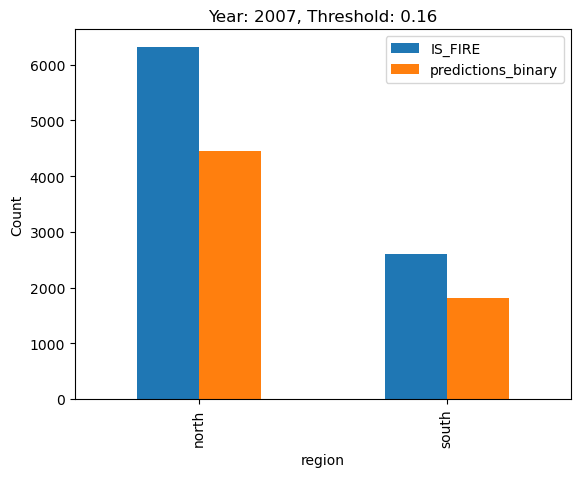

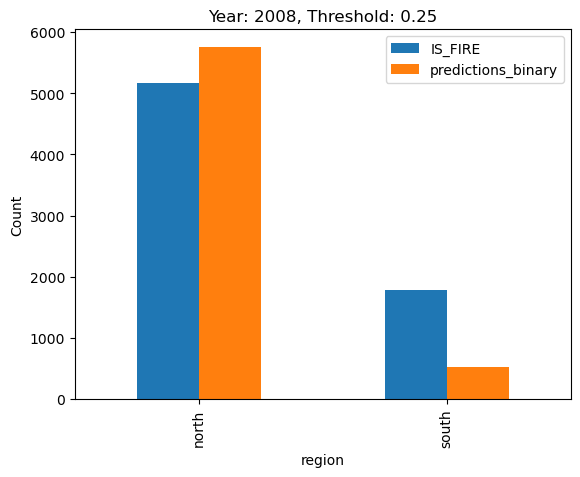

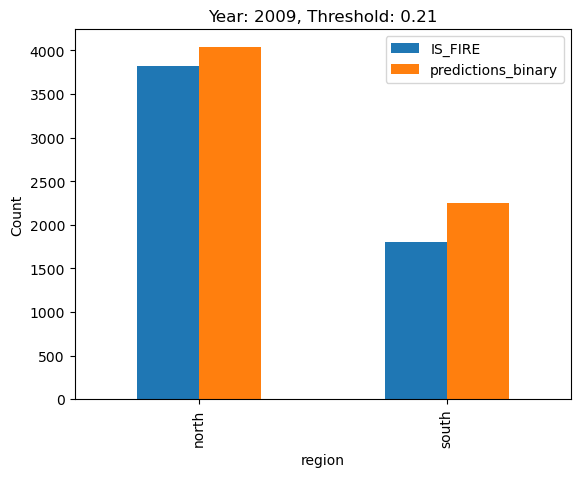

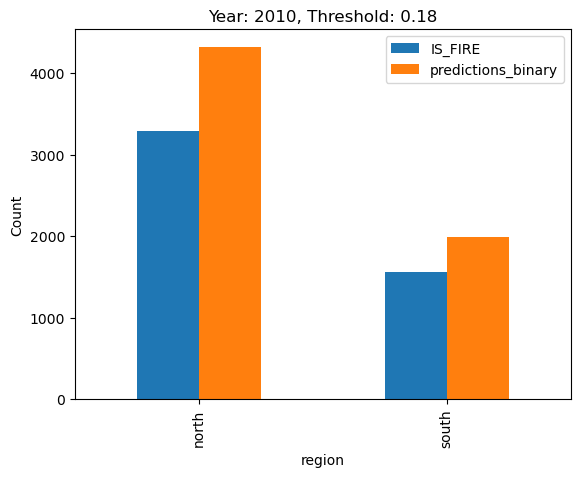

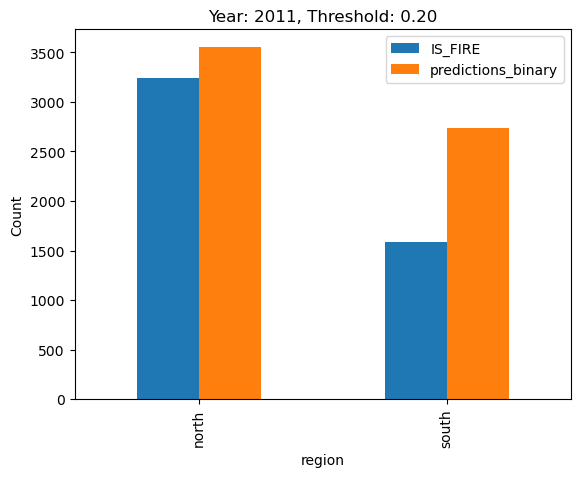

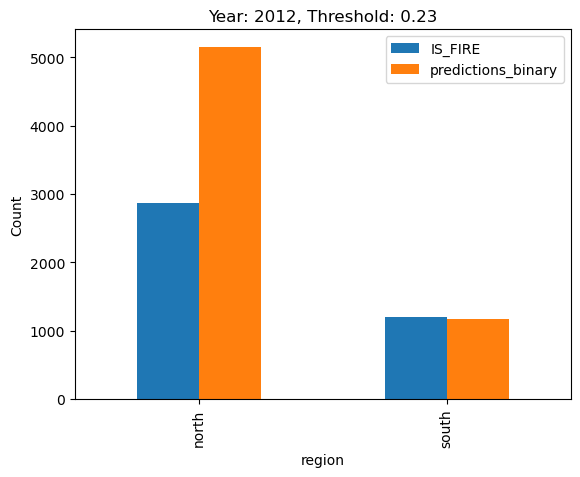

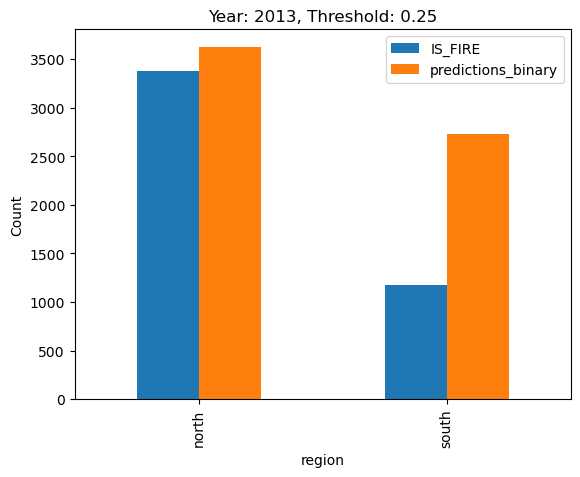

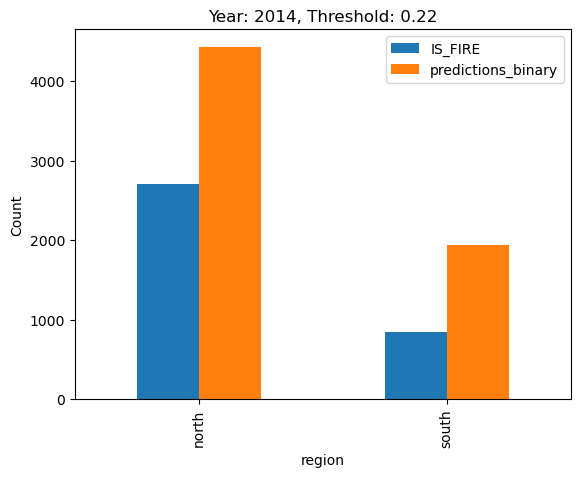

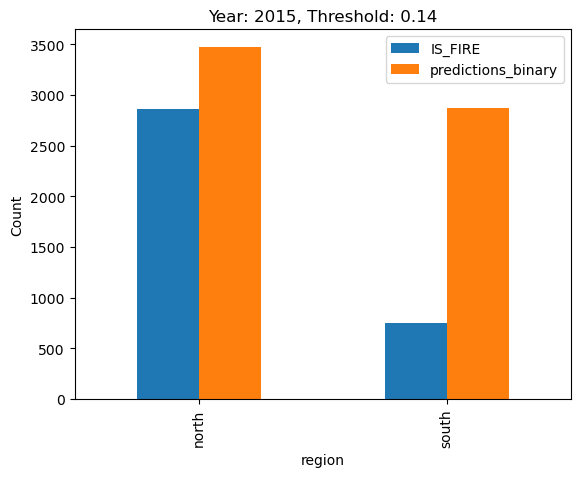

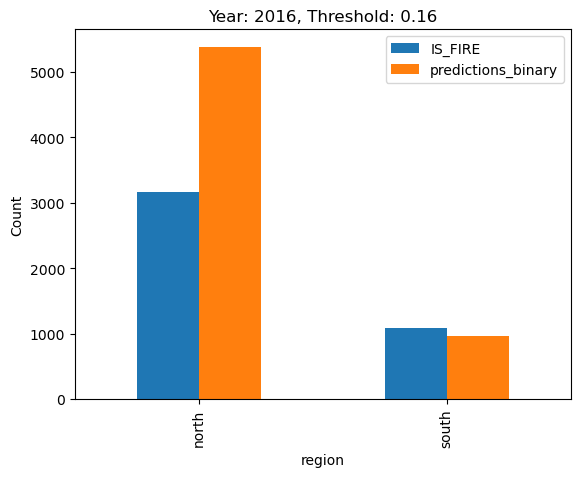

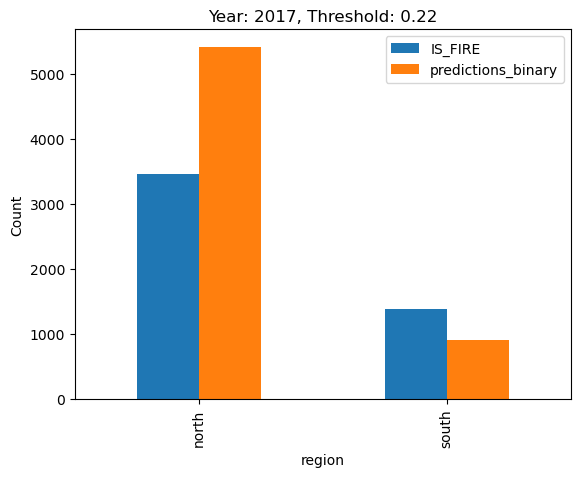

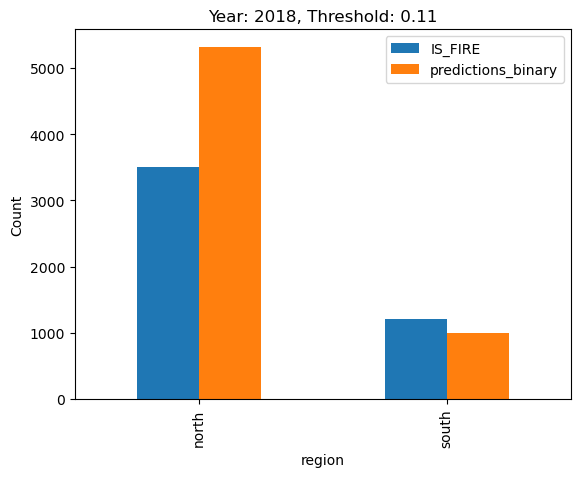

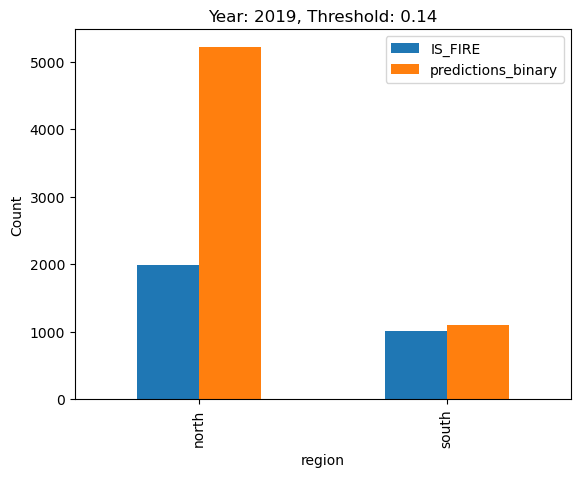

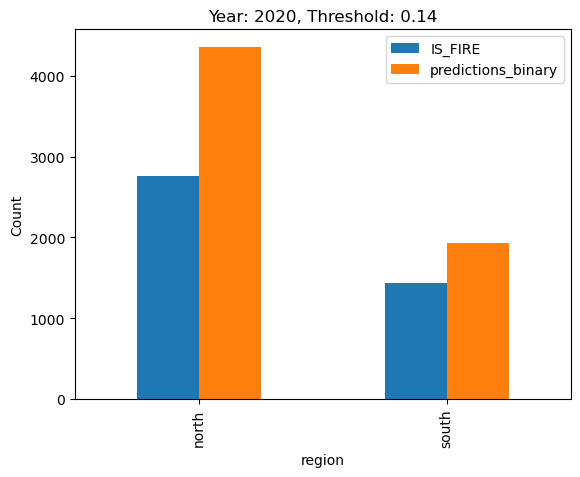

In [94]:
years = range(2007, 2021)


# Calculate the total number of iterations
total_iterations = len(years)

# surpress warnings
warnings.filterwarnings("ignore")

with tqdm(total=total_iterations, desc="Processing years") as pbar:
    for yr in years:
        # read data
        Eval_data = pd.read_parquet(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label/{yr}_features_w_label.parquet')
        # convert NWCG_CAUSE_CLASSIFICATION to string
        Eval_data['NWCG_CAUSE_CLASSIFICATION'] = Eval_data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
        Eval_data = Eval_data[(Eval_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (Eval_data['IS_FIRE'] == 0)]
        cat_columns = ['wind_direction_category','veg']
        Eval_data = pd.get_dummies(Eval_data, columns=cat_columns)


        model_path = f'../Model/predict_{yr}_6yr_model.json'
        mod = xgb.Booster()
        mod.load_model(model_path)

        # Ensure the columns in Eval_data match the model's feature names
        # common_columns = [col for col in mod.feature_names if col in Eval_data.columns]
        dmatrix_eval = xgb.DMatrix(Eval_data[mod.feature_names])
        Eval_data['predictions'] = mod.predict(dmatrix_eval)
        # assign threshold to be dynamic, 0.99 top percentile
        threshold = np.percentile(Eval_data['predictions'], 99.9)
        Eval_data['predictions_binary'] = (Eval_data['predictions'] > threshold).astype(int)

        # add a column called region
        Eval_data['region'] = np.where(Eval_data['lat'] < 35.75, 'south', 'north')

        # group by region, sum IS_FIRE and sum predictions_binary
        group_dat = Eval_data.groupby('region').agg({'IS_FIRE': 'sum', 'predictions_binary': 'sum'}).reset_index()

        # plot a bar plot, x axis is region, y axis is IS_FIRE and predictions_binary, side by side
        group_dat.plot(x='region', kind='bar', stacked=False)
        # add title to include year and threshold (round to 2 decimal places)
        plt.title(f'Year: {yr}, Threshold: {threshold:.2f}')
        plt.ylabel('Count')
        plt.savefig(f'../Plot/Validate_Region/Validation_Year_{yr}.png')


        # clean the cache
        gc.collect()

        # Update the progress bar
        pbar.update(1)

save data

- previous version didn't contain lat and lon

In [99]:
years = range(2016, 2021)


# Calculate the total number of iterations
total_iterations = len(years)

# surpress warnings
warnings.filterwarnings("ignore")

with tqdm(total=total_iterations, desc="Processing years") as pbar:
    for yr in years:
        # read data
        Eval_data = pd.read_parquet(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label/{yr}_features_w_label.parquet')
        # convert NWCG_CAUSE_CLASSIFICATION to string
        Eval_data['NWCG_CAUSE_CLASSIFICATION'] = Eval_data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
        Eval_data = Eval_data[(Eval_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (Eval_data['IS_FIRE'] == 0)]
        cat_columns = ['wind_direction_category','veg']
        Eval_data = pd.get_dummies(Eval_data, columns=cat_columns)


        model_path = f'../Model/predict_{yr}_6yr_model.json'
        mod = xgb.Booster()
        mod.load_model(model_path)

        # Ensure the columns in Eval_data match the model's feature names
        # common_columns = [col for col in mod.feature_names if col in Eval_data.columns]
        dmatrix_eval = xgb.DMatrix(Eval_data[mod.feature_names])
        Eval_data['predictions'] = mod.predict(dmatrix_eval)
        # assign threshold to be dynamic, 0.99 top percentile
        threshold = np.percentile(Eval_data['predictions'], 99.9)
        Eval_data['predictions_binary'] = (Eval_data['predictions'] > threshold).astype(int)
        Eval_data.to_csv(f'../Clean_Data/Model_Data/Evaluation/Predictions/{yr}_predictions.csv', index=False)
        # clean the cache
        gc.collect()

        # Update the progress bar
        pbar.update(1)

Processing years: 100%|██████████| 5/5 [20:27<00:00, 245.43s/it]
